<a href="https://colab.research.google.com/github/polina-minaeva/time-series-analysis-methods/blob/main/2_%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмем датасет о ежемесячных покупках машин в Квебеке. Временный ряд и временный ряд, приведенный к стационарности, приблизим с помощью моделей группы MA – TEMA и EMA.

In [ ]:
import pandas as pd

In [ ]:
car_sales = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

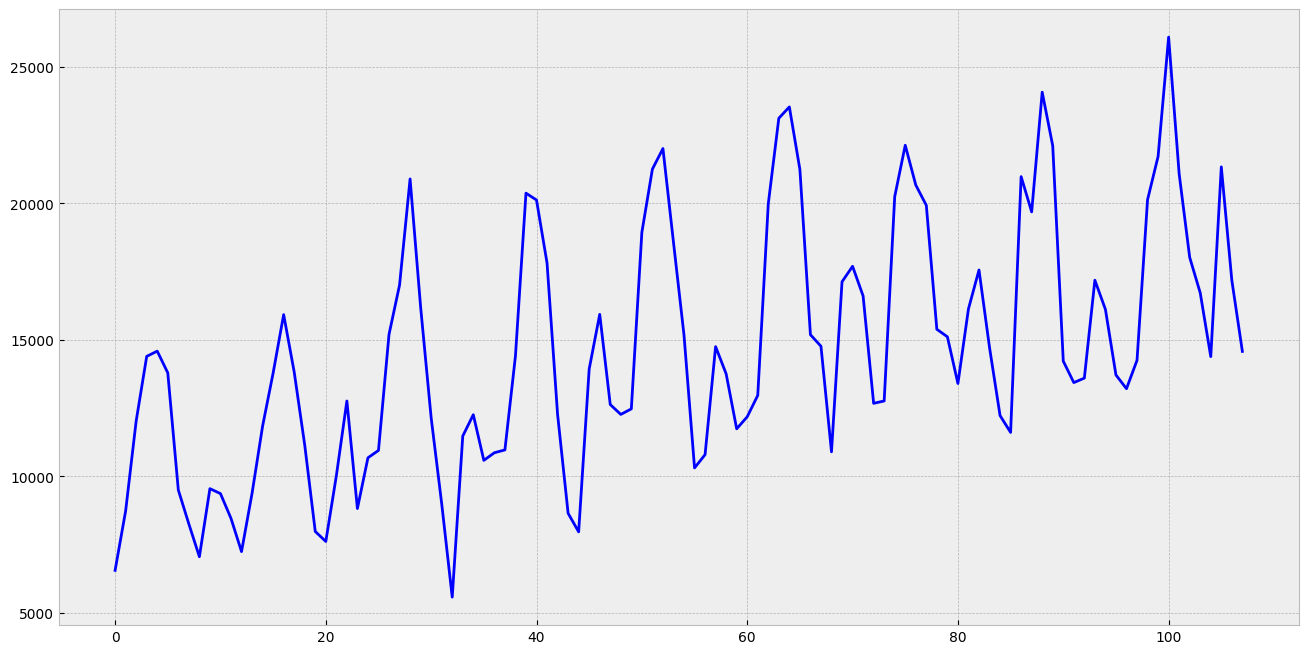

In [ ]:
with plt.style.context('bmh'): #так выглядят изначальные данные
    plt.figure(figsize=(16, 8))
    plt.plot(car_sales["Count"], color='blue')

Теперь приведем временный ряд к стационарному. Для этого сначала прологарифмируем его с помощью boxcox, а затем продифференцируем

In [ ]:
from scipy.stats import boxcox

In [ ]:
or_series = boxcox(car_sales["Count"], 0)

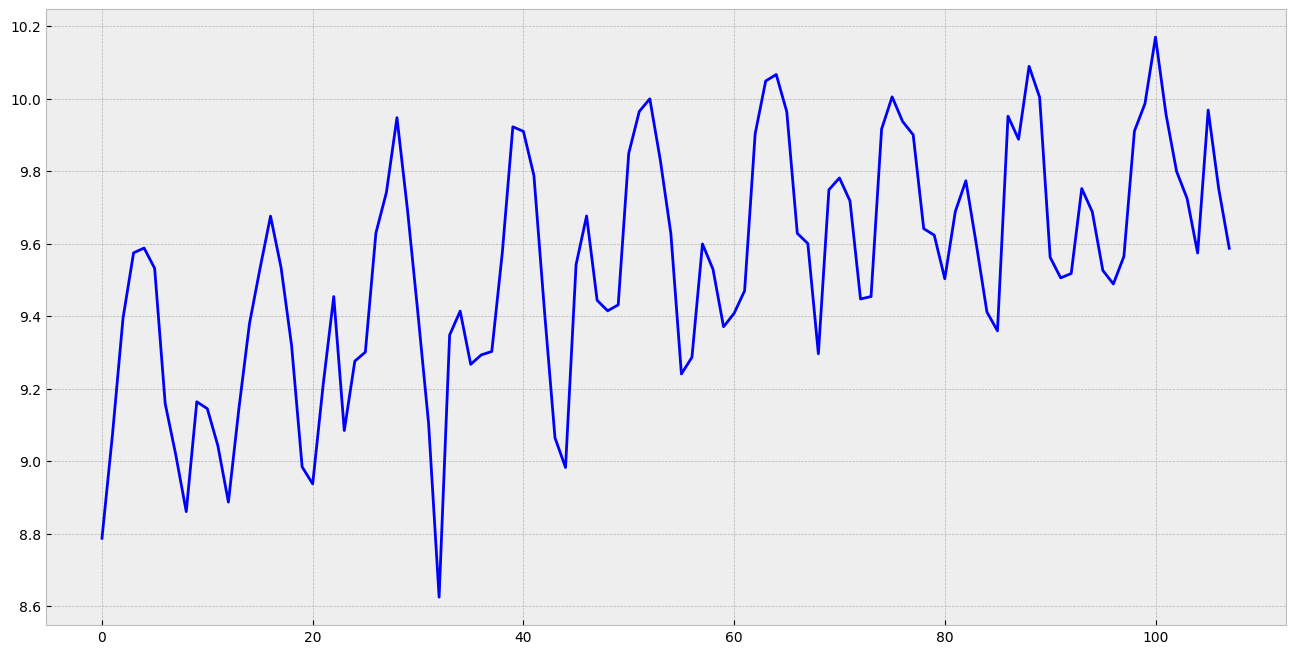

In [ ]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(or_series, color='blue')

In [ ]:
import numpy as np

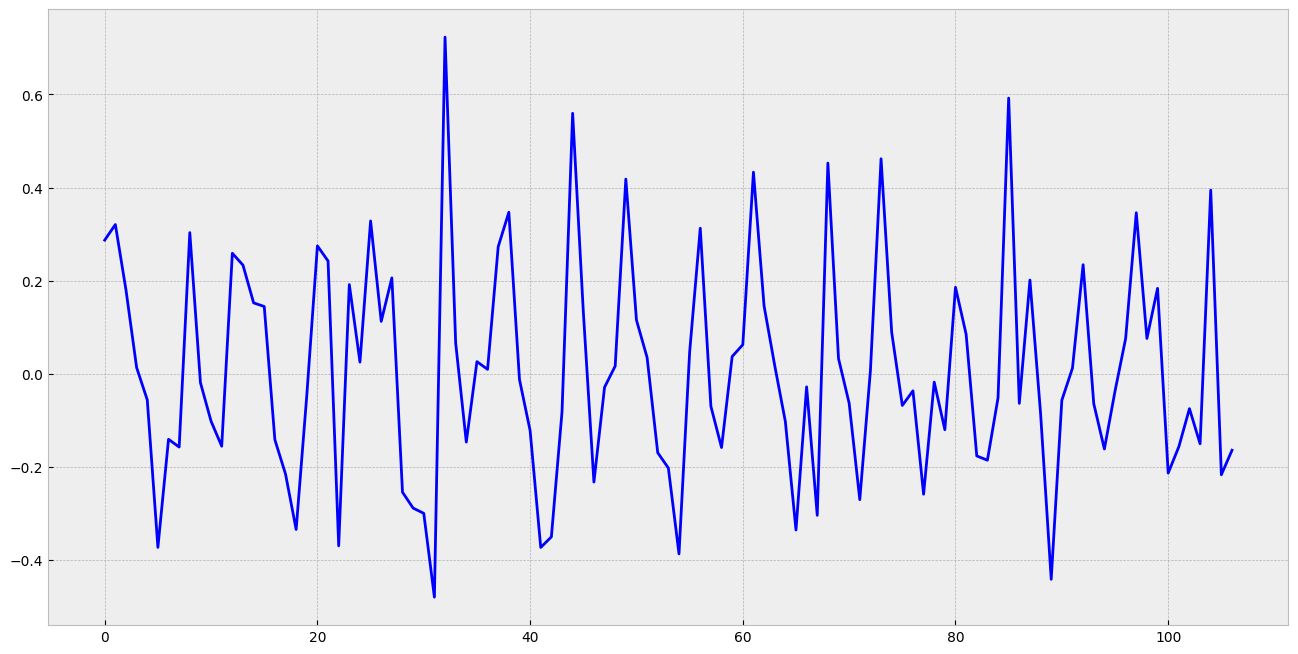

In [ ]:
sta_series = np.diff(or_series, 1)

with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(sta_series, color='blue')

Теперь приблизим временные ряды: изначальный и стационарный

Берем изначальный временный ряд и применим на нем тройное экспоненциальное сглаживание. Выбираем именно эту модель, чтобы учитывать тренд, сезонность и вес значений

In [ ]:
#создаем функции для подсчета

def initial_trend(series, season_len): #тренд
    for i in range(len(series)+1):
      return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen): #сезонность
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds): #функция тройного экспоненциального сглаживания
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
ser = car_sales["Count"]

In [ ]:
train, val = ser[:90], ser[90:]

Для анализа качества модели используем MSE

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#Делим выборку на трейн и тест. Оптимизируем параметры альфа, бета, гамма модели TEMA

from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:
from scipy.optimize import minimize

In [ ]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

75843146.15013461------------
74706095.66293749------------
75843146.15013461------------
75747959.64803466------------
75019876.16455318------------
74477665.96721871------------
73807266.67228028------------
73296754.98298325------------
72111429.43041472------------
72081666.59650159------------
70671000.76518703------------
69770247.06891942------------
67467752.42193155------------
66542931.65383942------------
63276535.73372499------------
62452609.74225229------------
58287123.237675585------------
56187897.05169401------------
50481055.33858609------------
48687807.162250556------------
42034540.130091995------------
39857651.33335843------------
32743974.14581099------------
30152754.245497417------------
23409486.567934636------------
21589933.371448398------------
16267990.085167617------------
14766242.553577775------------
11169869.693542162------------
10246694.897676976------------
8189535.412334458------------
7729904.485738788------------
6717757.855535018------------


In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x #получили лучшие варианты параметров
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5404500.432725096
             x: [ 7.653e-01  0.000e+00  0.000e+00]
           nit: 85
          nfev: 166
 final_simplex: (array([[ 7.653e-01,  0.000e+00,  0.000e+00],
                       [ 7.653e-01,  0.000e+00,  0.000e+00],
                       [ 7.653e-01,  0.000e+00,  0.000e+00],
                       [ 7.653e-01,  0.000e+00,  0.000e+00]]), array([ 5.405e+06,  5.405e+06,  5.405e+06,  5.405e+06]))


In [ ]:
alpha_opt

0.7653277745506266

In [ ]:
opt.x

array([0.76532777, 0.        , 0.        ])

In [ ]:
def plot_tema(alpha, beta, gamma, ser=car_sales["Count"], ser_to_plot=car_sales["Count"], n_preds=24): #теперь можем строить график
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

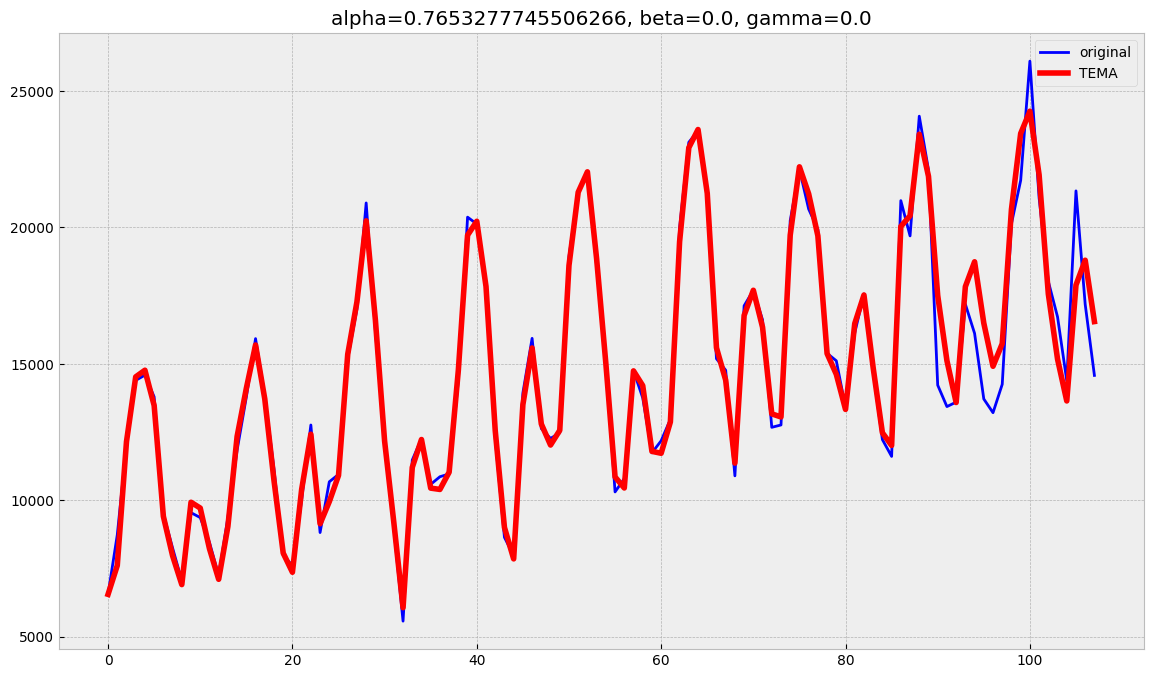

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=ser, n_preds=len(val))

Мы построили модель, оптимизировали параметры альфа, бета и гамма и с самыми лучшими построили график TEMA, который стремится повторить оригинальный временной ряд

Теперь вернемся к стационарному ряду. Для него мы можем не учитывать сезонность и тренд, поэтому применим взвешенное скользящее среднее VMA

In [ ]:
def exponential_moving_average(series, alpha): #строим функцию
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [ ]:
ema = exponential_moving_average(sta_series, 0.2) #вносим значения стационарного ряда sta_series

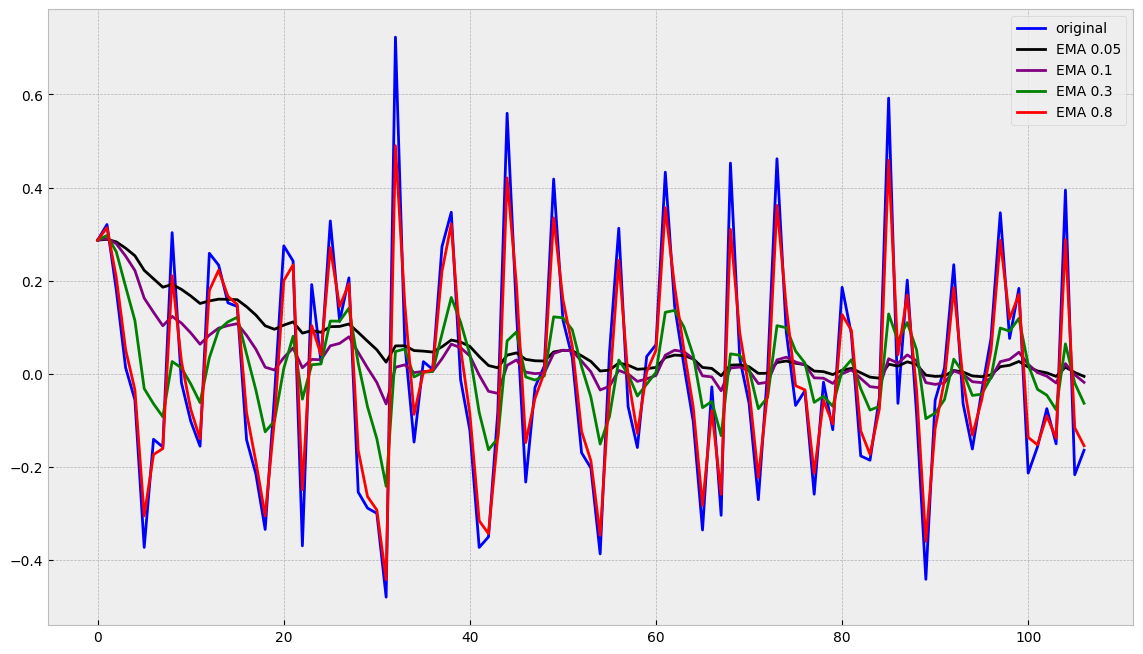

In [ ]:
alphas = [0.05,0.1,0.3,0.8] #посмотрим, как угадают временный ряд модели EMA с разными альфа
colors = ['black', 'purple', 'green', 'red']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(sta_series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(sta_series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Самое близкое к оригиналу - график EMA с альфой 0,8.

Итоги. Мы приблизили временные ряды с помощью моделей группы MA. Для обычного временного ряда, в котором нам важно учитывать тренд, сезонность и весы значений, мы применили TEMA. Для стационарного ряда мы применили EMA.